In [2]:
# Useful bits
import re
import json
import os.path
import pandas as pd
import numpy as np

# Interactive Computing
from IPython.display import display
import time
from tqdm import tqdm
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=0)

# LDA
from gensim.models import Phrases
from gensim.models import LdaModel
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP
import spacy
from spacy.tokens import Doc
from spacy.tokens import DocBin
print(spacy.__version__)

3.1.2


In [33]:
cleaned_dataframe_name = 'na_dropped.pkl'

if os.path.isfile(cleaned_dataframe_name):
    na_dropped = pd.read_pickle('na_dropped.pkl')
else:
    all_levels = pd.read_pickle('all_levels.pkl')
    all_levels = all_levels.dropna(axis=0)
    all_levels['text'] = all_levels['text'].astype(str)
    all_levels['text'] = all_levels['text'].str.replace(r'\s+', r' ', regex=True)
    na_dropped = all_levels
    na_dropped.to_pickle('na_dropped.pkl')
        

texts = na_dropped['text'].tolist()
display(len(texts))
# display(na_dropped)
display(texts[5:11])

549281

[" Hi! My name's Jianwen . I'm thirty years old. I'm from inner mongolia, in China. How are you? Nice to meet you! Bye! Jianwen ",
 " Hello! My name is Zhang Jianwen. I'm thirty years old. I'm form Inner Mongolia. I live in BaoTou City. There are four people in my family: my father, my mother, my sister and I. My mother and my father are both fifty-six years old. My sister is thirty-one years old. All of us are live in BaoTou City. Thank you for your letter! See you! Jianwen Sorry, no photos. ",
 " Hello! My name is Jianwen Zhang. I'm thirty. I'm from Inner Mongolia, China. I live in Baotou city. I'm an engineer and I work in a coal mine. I like my job. ",
 ' Sherry will contact Alison Bright form Big Hat and ask for their requirement by the next meeting.Alex and his tean will brainstorm some possible ideas for the next meeting.Sam will take the table for 18 in Japanese restautant . ',
 ' Dear teacher, I am robyn gu, coming from Wuxi and major in chemistry, currently work in sasol comp

In [37]:
na_dropped.author_id.value_counts()

18838770    246
19248365    158
18843435    150
19157555    150
21858287    132
           ... 
18459398      1
18716959      1
19348998      1
21081673      1
24650529      1
Name: author_id, Length: 84993, dtype: int64

In [4]:
# Run corpus through the spaCy pipeline

def process_docs(texts):
    if os.path.isfile('efcamdat.spacy'):
        # Deserialize .spacy
        nlp = spacy.blank("en")
        with open ('efcamdat.spacy', 'rb') as f:
            bytes_data = f.read()
        doc_bin = DocBin().from_bytes(bytes_data)
        docs = list(doc_bin.get_docs(nlp.vocab)) 
    else:
        # Let spaCy do its thing
        # 30 minutes with small model, probably 12 hours with transformer-based model
        nlp = spacy.load("en_core_web_sm")
        doc_bin = DocBin(attrs=["ORTH", "TAG", "HEAD", "DEP", "LEMMA", "MORPH", "POS"], store_user_data=False)
        docs = list(tqdm(nlp.pipe(texts))) 
        # Save processed .spacy
        for doc in docs:
            doc_bin.add(doc)
        bytes_data = doc_bin.to_bytes()
        with open ('efcamdat.spacy', 'wb') as f:
            f.write(bytes_data)       
    return docs

In [5]:
# Remove punctuation, stop words, and digits
# Make all words lowercase
# We can add to the stop words list here, or use other measures to eliminate uninteresting words (TF-IDF, Dispersion)

def reduce_tokens(docs):
    processed_docs = []
    for doc in docs:
        processed_doc = []
        for token in doc:
            if not token.is_punct and not token.is_stop and not token.is_digit:
                processed_doc.append(token.lemma_.lower())
        processed_docs.append(processed_doc)
    return processed_docs

In [6]:
# Compute bigrams.
# Add bigrams to docs (only ones that appear 20 times or more).

def compute_bigrams(processed_docs):
    bigram = Phrases(processed_docs, min_count=20)
    for idx in range(len(processed_docs)):
        for token in bigram[processed_docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                processed_docs[idx].append(token)
    return processed_docs

In [7]:
processed_docs_filename = "processed_docs.json"

if os.path.isfile(processed_docs_filename):
    print('Retrieving processed corpus from file')
    with open(processed_docs_filename) as f:
        processed_docs = json.load(f)
    print('Retrieved')
else:
    print('Nothing found.')
    spacy_docs = process_docs(texts)
    reduced_docs = reduce_tokens(spacy_docs)
    processed_docs = compute_bigrams(reduced_docs)
    print('Corpus Processed.')
    with open(processed_docs_filename, 'w') as f:
        json.dump(processed_docs, f)
    

Retrieving processed corpus from file
Retrieved


In [8]:
# Remove rare and common tokens.
# Create a dictionary representation of the documents.
dictionary = Dictionary(processed_docs)
print('Number of unique tokens: %d' % len(dictionary))

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 251313
Number of unique tokens: 24963


In [9]:
# Make a bag of words.
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
print('Number of documents: %d' % len(corpus))

Number of documents: 549281


In [10]:
def latent_dirichlet_allocation(input_corpus, input_dictionary):

    # Set training parameters.
    chunksize = 600000
    passes = 10
    iterations = 50
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    
    # Make an index to word dictionary.
    temp = input_dictionary[0]  # This is only to "load" the dictionary.
    id2word = input_dictionary.id2token
    
    # Train LDA model.
    start_time = time.time()
    
    model = LdaModel(
        corpus=input_corpus,
        id2word=id2word,
#         chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return(model)

In [11]:
num_topics = 12
model_filename = os.path.join('gensim_models', '{n}_topics'.format(n=num_topics), 'LDA_EFCAMDAT_{n}.gensim'.format(n = num_topics))

if os.path.isfile(model_filename):
    print('Retrieving Topics from File')
    model = LdaModel.load(model_filename)
    print('Done.')
else:
    print('No model with {n} topics found. Extracting {n} topics.'.format(n=num_topics))
    model = latent_dirichlet_allocation(corpus, dictionary)
    print('Topics Extracted')
    model.save(model_filename)
    p = gensimvis.prepare(model, corpus, dictionary)
    pyLDAvis.save_html(p, 'pyLDAvis_{n}.html'.format(n = num_topics))
    print('Vizualization saved.')


Retrieving Topics from File
Done.


In [14]:
# Compute Perplexity Score
# print('/nPerplexity Score: ', model.log_perplexity(corpus))

# Compute Coherence Score
# coherence_model_lda = CoherenceModel(model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('/nCoherence Score: ', coherence_lda)

In [15]:
# Get the documentxtopics as tuples
document_topics = model.get_document_topics(corpus, minimum_probability=0, minimum_phi_value=None, per_word_topics=False)

# print(len(document_topics))
# for docstats in document_topics[:10]:
#     print(docstats)

# Create a label list for topics 1-12
topic_cols = []
for i in range(1,13):
    topic_cols.append('topic_{}'.format(i))
    
# Get the topics for each document using list comprehension
topics_by_sample = pd.DataFrame([[y[1] for y in  x] for x in tqdm(document_topics)], columns=topic_cols)
display(topics_by_sample)

100%|██████████| 549281/549281 [01:01<00:00, 8950.69it/s]


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
0,0.015462,0.201705,0.026523,0.016459,0.143042,0.010347,0.018969,0.353753,0.034896,0.071614,0.052057,0.055173
1,0.018468,0.052858,0.013427,0.019658,0.433904,0.012359,0.022656,0.019188,0.041680,0.092145,0.127742,0.145914
2,0.013752,0.036420,0.009850,0.110809,0.126665,0.032539,0.200480,0.014223,0.129238,0.104532,0.030991,0.190502
3,0.013317,0.036717,0.074319,0.013879,0.261762,0.008649,0.113681,0.013308,0.079749,0.060788,0.029726,0.294105
4,0.014340,0.041337,0.462023,0.015264,0.085125,0.009597,0.179746,0.014755,0.033516,0.067053,0.032316,0.044928
...,...,...,...,...,...,...,...,...,...,...,...,...
549276,0.168829,0.124566,0.022801,0.009093,0.214670,0.022398,0.047160,0.007723,0.034348,0.122719,0.095761,0.129934
549277,0.008089,0.096401,0.047054,0.064883,0.247985,0.005386,0.100609,0.008261,0.096351,0.093816,0.036908,0.194257
549278,0.006469,0.210810,0.019909,0.023981,0.153543,0.004342,0.008253,0.006662,0.046515,0.236881,0.135279,0.147356
549279,0.022180,0.139905,0.004498,0.024428,0.377677,0.004238,0.030215,0.006496,0.029046,0.150884,0.089829,0.120604


In [16]:
# join efcamdat data to topic data
full_df = na_dropped.join(topics_by_sample, how =  'outer')

# save to pickle
# full_df.to_pickle(pkl_filename)

# coerce grade column to integers
full_df['grade'] = pd.to_numeric(full_df['grade'].astype(str), errors='coerce').fillna(0).astype(int)
full_df['lvl'] = pd.to_numeric(full_df['lvl'].astype(str), errors='coerce').fillna(0).astype(int)

# create full correlations table
topic_corrs = full_df.corr()
# display(topic_corrs)

# create targeted correlations tables
# topic_corrs = df.corrwith(full_df['grade'])
# topic_corrs = df.corrwith(full_df['lvl'])
# display(topic_corrs)


In [14]:
# Which prompts are most associated with which topics?
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


x = topics_by_sample[:50000]
y = full_df.topic[:50000]
regmodel = LogisticRegression(solver='liblinear', random_state=0)
regmodel.fit(x, y)

confusion_matrix(y, regmodel.predict(x))

regmodel.predict(x)

print(classification_report(y, regmodel.predict(x)))

                                     precision    recall  f1-score   support

 Describing your family in an email       0.92      0.93      0.93      5463
      Introducing yourself by email       0.77      0.87      0.82     13081
         Making a dinner party menu       0.88      0.96      0.92      2911
    Signing up for a dating website       0.99      0.93      0.96      4314
     Taking inventory in the office       1.00      0.96      0.98      8011
       Updating your online profile       0.66      0.58      0.62      4895
          Writing an online profile       0.70      0.67      0.68      7082
Writing labels for a clothing store       0.99      0.88      0.93      4243

                           accuracy                           0.85     50000
                          macro avg       0.86      0.85      0.85     50000
                       weighted avg       0.85      0.85      0.84     50000



In [17]:
# Create a dataframe for documents x topics
col_list = ['topic']
col_list.extend(topic_cols)
display(col_list)
topics_only = full_df[col_list]
display(topics_only)

['topic',
 'topic_1',
 'topic_2',
 'topic_3',
 'topic_4',
 'topic_5',
 'topic_6',
 'topic_7',
 'topic_8',
 'topic_9',
 'topic_10',
 'topic_11',
 'topic_12']

,topic,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
0,Writing labels for a clothing store,0.015462,0.201705,0.026523,0.016459,0.143042,0.010347,0.018969,0.353753,0.034896,0.071614,0.052057,0.055173
1,Introducing yourself by email,0.018468,0.052858,0.013427,0.019658,0.433904,0.012359,0.022656,0.019188,0.041680,0.092145,0.127742,0.145914
2,Introducing yourself by email,0.013752,0.036420,0.009850,0.110809,0.126665,0.032539,0.200480,0.014223,0.129238,0.104532,0.030991,0.190502
3,Introducing yourself by email,0.013317,0.036717,0.074319,0.013879,0.261762,0.008649,0.113681,0.013308,0.079749,0.060788,0.029726,0.294105
4,Taking inventory in the office,0.014340,0.041337,0.462023,0.015264,0.085125,0.009597,0.179746,0.014755,0.033516,0.067053,0.032316,0.044928
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549276,Writing about a symbol of your country,0.168829,0.124566,0.022801,0.009093,0.214670,0.022398,0.047160,0.007723,0.034348,0.122719,0.095761,0.129934
549277,Attending a robotics conference,0.008089,0.096401,0.047054,0.064883,0.247985,0.005386,0.100609,0.008261,0.096351,0.093816,0.036908,0.194257
549278,Using creative writing techniques,0.006469,0.210810,0.019909,0.023981,0.153543,0.004342,0.008253,0.006662,0.046515,0.236881,0.135279,0.147356
549279,Writing about a symbol of your country,0.022180,0.139905,0.004498,0.024428,0.377677,0.004238,0.030215,0.006496,0.029046,0.150884,0.089829,0.120604


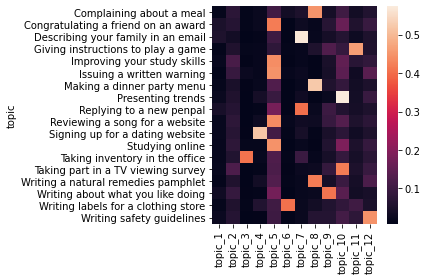

In [18]:
mean_topic = topics_only.groupby(['topic']).mean()
# display(mean_topic[(mean_topic > .45).any(1)])

ax = sns.heatmap(mean_topic[(mean_topic > .4).any(1)])
plt.tight_layout()
plt.show(ax)

# full_df['topic_id'] = pd.to_numeric(full_df['topic_id'].astype(str), errors='coerce').fillna(0).astype(int)
# sns.regplot(x=full_df.topic_3, y=full_df.topic.astype(str), logistic=True)

# fig = ax.get_figure()
# fig.savefig('prompt_topic_heatmap_{n}.png'.format(n = num_topics)) 

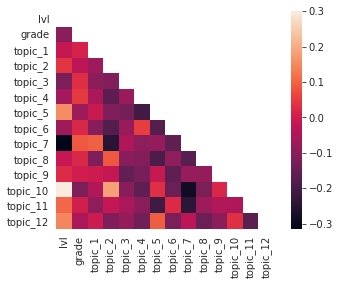

In [22]:
import numpy as np

# cx = sns.heatmap(topic_corrs)
# plt.show(cx)

# This code just masks redundant cells white
mask = np.zeros_like(topic_corrs)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
#     f, ax = plt.subplots(figsize=(7, 5))
    cx = sns.heatmap(topic_corrs, mask=mask, vmax=.3, square=True)

plt.show(cx)

fig = cx.get_figure()
fig.savefig('grade_level_topic_heatmap_{n}.png'.format(n = num_topics)) 

In [23]:
# This is an excessive amount of code to nicely print some basic information...
for prompt in mean_topic[(mean_topic > .4).any(1)].index:
    print(prompt, end=':\n')
    print('Level',
          full_df[full_df.topic == prompt].lvl.iloc[1],
          '--',
          full_df[full_df.topic == prompt].lvl.value_counts().iloc[0],
          'essays',
          end='\n'*2)

Complaining about a meal:
Level 6 -- 2471 essays

Congratulating a friend on an award:
Level 8 -- 1658 essays

Describing your family in an email:
Level 1 -- 18009 essays

Giving instructions to play a game:
Level 7 -- 13011 essays

Improving your study skills:
Level 11 -- 492 essays

Issuing a written warning:
Level 7 -- 3129 essays

Making a dinner party menu:
Level 1 -- 10384 essays

Presenting trends:
Level 10 -- 910 essays

Replying to a new penpal:
Level 3 -- 9333 essays

Reviewing a song for a website:
Level 8 -- 2078 essays

Signing up for a dating website:
Level 1 -- 14165 essays

Studying online:
Level 9 -- 1793 essays

Taking inventory in the office:
Level 1 -- 26453 essays

Taking part in a TV viewing survey:
Level 7 -- 3425 essays

Writing a natural remedies pamphlet:
Level 8 -- 3460 essays

Writing about what you like doing:
Level 4 -- 9449 essays

Writing labels for a clothing store:
Level 1 -- 13985 essays

Writing safety guidelines:
Level 9 -- 1351 essays



Prompt = what the students were asked to write about
Topic = Product of LDA

I want to remove any prompts that have an association with a single topic that is BOTH:
1. mean topic score > .4
2. At least .2 higher than the second highest topic mean for that prompt.

e.g. if "write about travel plans" has a mean topic score of .45, and the second best mean-topic score is "talk about your plans for the future" at .29, then we should elminate "write about travel plans" from the analysis, but if many prompts have a mean score at the .3-.5 level for the same topic, then we don't need to remove them.


Akshually, I should probably just remove outliers...

In [24]:
# display(topics_only)
# display(mean_topic)
# mean_topic[(mean_topic > .4).any(1)]

from scipy import stats

# Find all prompts for which any mean topic score is greater than or equal to 4 standard deviations from the mean
# Create a new dataframe with all the data, minus any document-rows that correspond with one of these outlier prompts
outliers = mean_topic[(np.abs(stats.zscore(mean_topic)) >= 4).any(axis=1)]
outliers_removed_full = full_df[~full_df.topic.isin(outliers.index)]
display(outliers_removed_full.topic.value_counts())

# Grab all prompts less than 4 standard deviations from the mean
outliers_removed = mean_topic[(np.abs(stats.zscore(mean_topic)) < 4).all(axis=1)]
display(outliers_removed)


Introducing yourself by email       42978
Writing an online profile           23108
Writing about what you do           21126
Updating your online profile        16626
Describing routines                 15837
                                    ...  
Following a code of ethics             80
Making a movie                         74
Researching a legendary creature       73
Writing a visualization script         72
Applying for a home loan               66
Name: topic, Length: 104, dtype: int64

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
topic,,,,,,,,,,,,
Applying for a home loan,0.028100,0.112448,0.060451,0.017955,0.171589,0.082533,0.038393,0.034841,0.061678,0.179244,0.090876,0.121892
Applying for sponsorship,0.028385,0.090832,0.017598,0.023191,0.362753,0.012864,0.018179,0.021372,0.055048,0.200769,0.047995,0.121014
Asking a friend to shop for you,0.018202,0.051462,0.016606,0.034391,0.135711,0.051374,0.027973,0.374709,0.083176,0.108058,0.043777,0.054562
Asking for leave,0.025979,0.143047,0.021165,0.017131,0.261877,0.010535,0.120417,0.022652,0.066129,0.160276,0.058450,0.092342
Attending a leadership course,0.036319,0.088920,0.010235,0.036628,0.258233,0.007553,0.021224,0.012336,0.037592,0.274999,0.048331,0.167630
...,...,...,...,...,...,...,...,...,...,...,...,...
Writing an autobiography,0.053248,0.048387,0.012719,0.018205,0.220796,0.010094,0.206790,0.013930,0.122543,0.102868,0.039770,0.150649
Writing an email of advice,0.021970,0.092443,0.012400,0.016656,0.244438,0.019304,0.031544,0.022810,0.057628,0.301189,0.102212,0.077407
Writing an online profile,0.067493,0.072244,0.014196,0.021225,0.179097,0.012534,0.230655,0.019354,0.084615,0.086683,0.042128,0.169778


I want to remove outliers from full_df, not just from mean_topic, so I can correlated with grad and level again.


I need to find the outlier prompts and select rows from full_df that are not associated with outlier prompts.

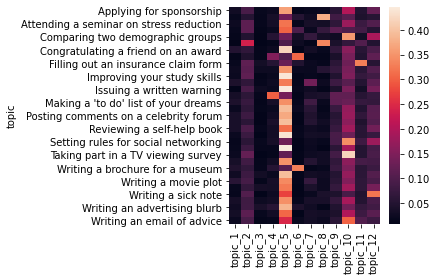

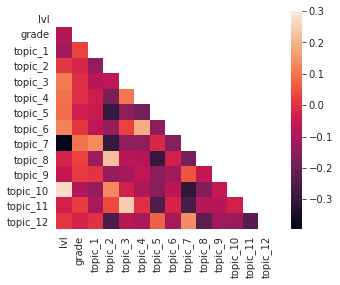

Congratulating a friend on an award:
Level 8 -- 1658 essays

Improving your study skills:
Level 11 -- 492 essays

Issuing a written warning:
Level 7 -- 3129 essays

Reviewing a song for a website:
Level 8 -- 2078 essays

Studying online:
Level 9 -- 1793 essays

Taking part in a TV viewing survey:
Level 7 -- 3425 essays



In [25]:
ax = sns.heatmap(outliers_removed[(abs(outliers_removed) > .3).any(1)])
plt.tight_layout()
plt.show(ax)

# create full correlations table
outliers_removed_corrs = outliers_removed_full.corr()

# This code just masks redundant cells white
mask = np.zeros_like(outliers_removed_corrs)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
#     f, ax = plt.subplots(figsize=(7, 5))
    cx = sns.heatmap(outliers_removed_corrs, mask=mask, vmax=.3, square=True)

plt.show(cx)

fig = cx.get_figure()

for prompt in outliers_removed[(outliers_removed > .4).any(1)].index:
    print(prompt, end=':\n')
    print('Level',
          full_df[full_df.topic == prompt].lvl.iloc[1],
          '--',
          full_df[full_df.topic == prompt].lvl.value_counts().iloc[0],
          'essays',
          end='\n'*2)

Probably the best 'learner proficiency' metric that we can get with this EFCAMDAT dataset is the mean 'grade' for each learner. This lets us see how well that learner performs on average.

In this implementation, we are averaging grade but not topic scores. So each essay/document is one data point, but all of the essay/documents for a given learner will have the same target (average learner grade). I am pretty sure this violates some assumptions of linear regression, but whatever.

In [26]:
## This was surprisingly tough...

# display(outliers_removed_full)
# learner_avg_grade = pd.Series(outliers_removed_full.groupby('author_id').grade.transform(np.mean).values, copy=False)

# outliers_removed_full['learner_avg_grade'] = outliers_removed_full.groupby('author_id').grade.transform(np.mean).values
# display(learner_avg_grade)
# outliers_removed_full['learner_avg_grade'] = learner_avg_grade

# Groupby author_id, select grade column, transform with the mean function (retains index of original by duplicating result value),
# and rename to 'learner_avg_grade'
# Concatenate the resulting series to the end of the existing dataframe
learner_avg_grade = outliers_removed_full.groupby('author_id').grade.transform(np.mean).rename('learner_avg_grade')
grade_averaged = pd.concat([outliers_removed_full, learner_avg_grade], axis=1)

# display(grade_averaged)
# display(outliers_removed_full.groupby('author_id').grade.transform(np.mean))

In [27]:
# delete rows where average grade is 0
grade_averaged.drop(grade_averaged[grade_averaged['learner_avg_grade'] < 70 ].index , inplace=True)

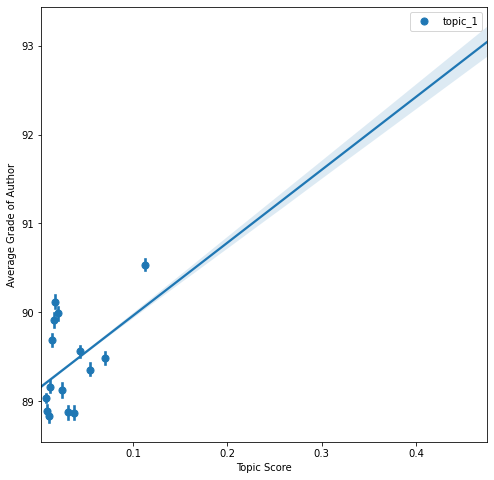

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.regplot(x="topic_1", y="learner_avg_grade", data=grade_averaged, x_bins=15, ax=ax, label="topic_1")
ax.set(ylabel='Average Grade of Author', xlabel='Topic Score')
ax.legend()
plt.show()

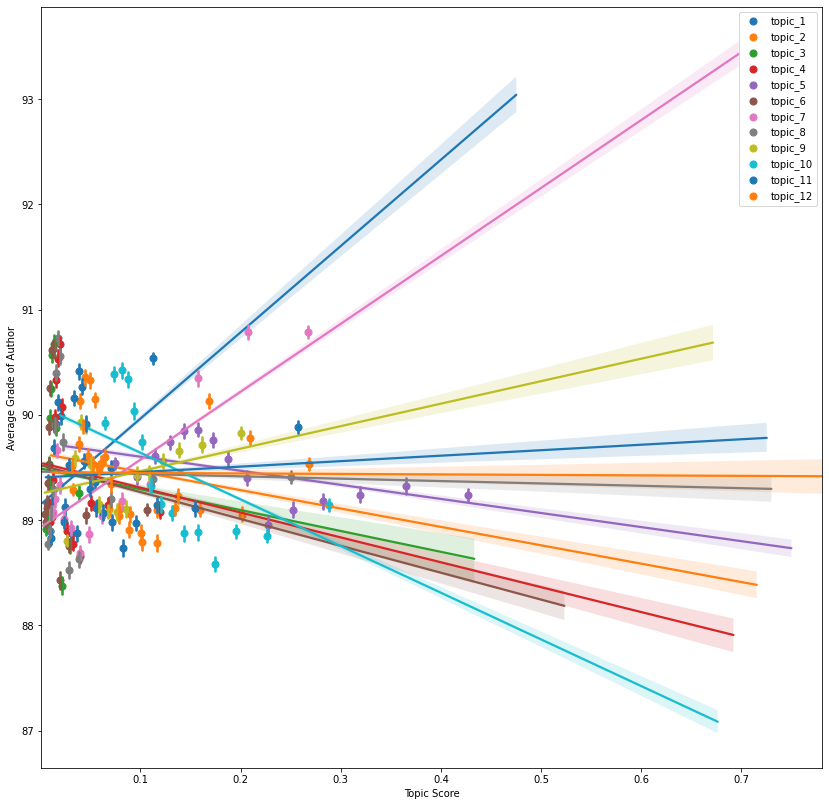

In [29]:
# I would love to combine these into one graph with a legend... still learning seaborn...

fig, ax = plt.subplots(figsize=(14, 14))

for topic in topic_cols:
    with sns.axes_style('white'):
        sns.regplot(x=topic,
                    y="learner_avg_grade",
                    data=grade_averaged,
                    x_bins=15,
                    ax=ax,
                    label=topic)
ax.set(ylabel='Average Grade of Author', xlabel='Topic Score')
ax.legend()
plt.show()

In [30]:
fig = ax.get_figure()
fig.savefig('avg_learner_grade_reg.png')